In [1]:
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)
import seaborn as sns
from salmon.triplets.offline import OfflineEmbedding
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from svgpathtools import parse_path
import cv2
from collections import Counter
import scipy
from collections import OrderedDict
import svgpathtools
import scipy.stats as stats
from scipy.spatial.distance import cdist, cosine, euclidean # distance metrics
import statsmodels.api as sm
import clip
from itertools import repeat

In [2]:
import matplotlib as mpl
lfont = {'fontname':'Helvetica'}
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_dir = os.path.abspath('..')
code_dir = os.getcwd()
data_dir = os.path.join(proj_dir,'data')

### Util functions

In [4]:
### General helper functions (TODO: move to utils.py)

def fft_image(image, high=False):   
    dft = cv2.dft(np.float32(image),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    rows, cols = image.shape
    crow,ccol = int(rows/2) , int(cols/2)

    mask = create_circular_mask(h=image.shape[0], w=image.shape[1], center=None, radius=10)
    if high==True:
        mask = 1-mask
    mask = np.stack((mask,mask),axis=2)

    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    return img_back


def getImage(path, zoom=.12):
    im = plt.imread(path)
    im =np.ma.masked_where(im == 0, im)
    return OffsetImage(im, zoom=zoom,cmap='gray')

def gen_feat_df(stim='fleming_adjusted',model_path ='alexnet_classifier.4', next_dims=2, show_pca=True):

    next_cols = ['embed_'+x for x in map(str,list(range(1,next_dims+1)))]
    feats = pd.DataFrame(np.load(f'../data/{stim}_stim_{model_path}/features/features.npy'))
    names=pd.read_csv(f'../data/{stim}_stim_{model_path}/targets/file_names.txt',header=None,names=['sketch_id'])
    feat_df =  pd.concat((feats,names),axis=1)
    feat_df.sketch_id = feat_df.sketch_id.apply(lambda x:x.split('.')[0])
    feat_cols = feat_df.columns[0:feats.shape[1]]
    if stim=='fleming_adjusted':
        feat_df['category'] = feat_df.sketch_id.apply(lambda x:x.split('-')[0])
        feat_df= pd.concat((feat_df, pd.DataFrame(salmon_fits_flem[next_dims-1].embedding_,columns=next_cols)),axis=1)
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(feat_df[feat_cols].values)
        feat_df['pca1'] = pca_result[:,0]
        feat_df['pca2'] = pca_result[:,1] 
        feat_df['pca3'] = pca_result[:,2]
            
    if stim=='sketches':
        render_df_meta = pd.read_csv(os.path.join(data_dir,'render_meta_data.csv'))

        _meta_df = pd.DataFrame(render_df_meta.groupby(['sketch_id','condition','category','target']).agg(dummy=pd.NamedAgg(column='num_strokes', aggfunc='max')))
        _meta_df=_meta_df.reset_index()
        feat_df= feat_df.join(_meta_df.set_index('sketch_id'), on = 'sketch_id')
        feat_df= pd.concat((feat_df, pd.DataFrame(salmon_fits_sketch[next_dims-1].embedding_,columns=next_cols)),axis=1)
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(feat_df[feat_cols].values)
        feat_df['pca1'] = pca_result[:,0]
        feat_df['pca2'] = pca_result[:,1] 
        feat_df['pca3'] = pca_result[:,2]
            

        

    if show_pca:
        print("Plotting...")


        fig1 = plt.figure(1,figsize=(15,10))
        sns.scatterplot(
            x="pca1", y="pca2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=feat_df,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 principal components of {stim} {model_path} features')
        plt.xlabel('principal component 1')
        plt.ylabel('principal component 2')
        ax = fig1.gca()
        x = feat_df['pca1'].values
        y = feat_df['pca2'].values
        paths = np.array([os.path.join(data_dir,f"{stim}_stim/",f"{x}.png") for x in feat_df['sketch_id'].values])
        sub_inds = np.random.choice(np.arange(len(x)), size=int(len(x)/3), replace=False)
   
        # for x0, y0, path in zip(x[sub_inds], y[sub_inds],paths[sub_inds]):
        #     ab = AnnotationBbox(getImage(path), (x0+np.random.normal(0,.05), y0+np.random.normal(0,.05)), frameon=False)
        #     ax.add_artist(ab)
        
        plt.show()
        

        fig2 = plt.figure(2,figsize=(15,10))
        sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=feat_df,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 triplet judgement embedding dimensions')
        plt.xlabel('dimension 1')
        plt.ylabel('dimension 2')
        
        ax = fig2.gca()
        x = feat_df['embed_1'].values
        y = feat_df['embed_2'].values
        paths = np.array([os.path.join(data_dir,f"{stim}_stim/",f"{x}.png") for x in feat_df['sketch_id'].values])
        sub_inds = np.random.choice(np.arange(len(x)), size=int(len(x)/3), replace=False)
   
        # for x0, y0, path in zip(x[sub_inds], y[sub_inds],paths[sub_inds]):
        #     ab = AnnotationBbox(getImage(path), (x0+np.random.normal(0,.05), y0+np.random.normal(0,.05)), frameon=False)
        #     ax.add_artist(ab)
        
        plt.show()
    return feat_df, feat_cols
                
                
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


def score(fdf, ndf, feat_cols, distmat=None):
    #print(distmat)
    if distmat is not None:
        mdist = distmat  
    else:
        mdist = scipy.spatial.distance.pdist(fdf[feat_cols], metric='euclidean')
        mdist = scipy.spatial.distance.squareform(mdist)
        
    o = np.zeros(ndf.shape[0])
    dist_df = pd.DataFrame(mdist, columns=fdf.sketch_id, index=fdf.sketch_id)
    
    mitems = dist_df.index
    nitems =ndf.shape[0]
    for i in range(nitems):
        ivec =  dist_df[dist_df.index==ndf['head_filename'].iloc[i].split('.')[0]]
        
    
        dleft = ivec[ndf['left_filename'].iloc[i].split('.')[0]].values
        dright = ivec[ndf['right_filename'].iloc[i].split('.')[0]].values
        if(dleft<dright):
            pred = ndf['left_filename'].iloc[i].split('.')[0]
        elif (dleft>dright):
            pred = ndf['right_filename'].iloc[i].split('.')[0]
        else:
            pred = [ndf['left_filename'].iloc[i].split('.')[0], ndf['right_filename'].iloc[i].split('.')[0]][int(np.random.binomial(1,.5,1))]
        if(pred==ndf.winner_filename.iloc[i].split('.')[0]):
            o[i] = 1
    return(o)





### Create a function to subset our dataframes by conditions as we need 

def subset_dataframe_by_condition(F,to_inspect='all',this_category='bird',this_object='bluejay'):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    F = F.sort_values(by=['category','target'])

    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    numstrokes_cols = [i for i in F.columns if i.split('_')[-1]=='numstrokes']
    arclength_cols = [i for i in F.columns if i.split('_')[-1]=='arclength']
    feat_cols = numstrokes_cols + arclength_cols
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
        obj_listf = F[(far_inds) & obj_inds]['target'].values
        obj_listc = F[(close_inds) & obj_inds]['target'].values
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
        obj_listf = F[(category_inds) & (far_inds)]['target'].values
        obj_listc = F[(category_inds) & (close_inds)]['target'].values
    elif to_inspect == 'all':
        ## extract particular rows corresponding to each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
        obj_listf = F[far_inds]['target'].values
        obj_listc = F[close_inds]['target'].values
        
    return c, f, obj_listc, obj_listf


## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

def listify(string):
    split_list = string.split("'")
    l=[", u","[u","]"]
    out = [x for x in split_list if x not in l]
    return(out)

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X


def plot_tscores(nn_model,stimulus,pca_coords,num_comps=2,plot=False,return_pred_mat=False):
        # '''
        # nn_model : vgg, resnet, vit, vit_nc, alex
        # '''
        if stimulus=='sketch':
               
                
                X = np.vstack([pca_coords[nn_model].components_[0:3], pca_coords['parts'].components_[0:3],\
                pca_coords['sm'].components_[0:3],pca_coords['cat'].components_[0:3],\
                pca_coords['fft_high'].components_[0:3],pca_coords['fft_low'].components_[0:3]]).T

                _X = sm.add_constant(X)
                pred_df = pd.DataFrame(np.hstack([_X,pca_coords['next'][0:2].T]), columns=['const','nn1','nn2','nn3','parts1','parts2','parts3','sm1','sm2','sm3','cat1','cat2','cat3','fft_high1','fft_high2','fft_high3','fft_low1','fft_low2','fft_low3','next1','next2'])
                pred_coords = np.array([])
                for comp in range(num_comps):
                        y = pca_coords['next'][comp]
                        model_c = sm.OLS(y, _X).fit()
                        model_sub = sm.OLS(y,  sm.add_constant(X[:,3:])).fit()
                        delta_r = (model_c.rsquared- model_sub.rsquared)
                        # model_c1.summary()


                        plt.figure(figsize=(12,5))
                        t_cmap = plt.get_cmap("tab20")

                        l = [list((t_cmap.colors[1],)*3),list((t_cmap.colors[3],)*3),list((t_cmap.colors[5],)*3),list((t_cmap.colors[7],)*3),list((t_cmap.colors[9],)*3),list((t_cmap.colors[11],)*3)]
                        t_colors = [item for sublist in l for item in sublist]

                        bar = plt.bar(np.arange(len(model_c.tvalues[1:])),np.abs(model_c.tvalues[1:]),color=t_colors)

                        for i,rect in enumerate(bar):
                                if model_c.pvalues[i+1]<0.001:
                                        annot = '***'
                                elif model_c.pvalues[i+1]<0.01:
                                        annot = '**'
                                elif model_c.pvalues[i+1]<0.05:
                                        annot = '*'
                                else:
                                        annot=''
                                height = rect.get_height()
                                plt.text(rect.get_x() + rect.get_width()/2.0, height-0.10, f'{annot}', ha='center', va='bottom', fontsize=15, fontweight='bold')

                        plt.xticks(np.arange(1,18,3),[f'{nn_model} comps','part comps','shape comps','category comps','fft_high','fft_low'], rotation=30)
                        plt.ylabel('t-score')
                        plt.xlabel('')
                        plt.title(f'Human Similarity Judgements Component {comp+1} ({nn_model})', fontsize=17,pad=10)
                        plt.ylim(0,15)
                        plt.savefig(f'{stimulus}_{nn_model}_{comp+1}.pdf',bbox_inches='tight',dpi=300)
                        if plot==False:
                                plt.close()
                        if stimulus=='sketch':
                                c_pred = model_c.predict().reshape(128,1)
                        elif stimulus=='flem':
                                c_pred = model_c.predict().reshape(64,1)
                        pred_coords = np.hstack([pred_coords,c_pred]) if pred_coords.size else c_pred
                coord_dmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(pred_coords, metric='euclidean'))
                if return_pred_mat:
                        return(coord_dmat,pred_df)
        elif stimulus=='flem':
                X = np.vstack([pca_coords[nn_model].components_[0:3],pca_coords['sm'].components_[0:3],\
                 pca_coords['fft_high'].components_[0:3],pca_coords['fft_low'].components_[0:3],pca_coords['overlap'].components_[0:3]]).T
                _X = sm.add_constant(X)
                pred_df = pd.DataFrame(np.hstack([_X,pca_coords['next'][0:2].T]), columns=['const','nn1','nn2','nn3','sm1','sm2','sm3','fft_high1','fft_high2','fft_high3','fft_low1','fft_low2','fft_low3','overlap1','overlap2','overlap3','next1','next2'])
                pred_coords = np.array([])
                for comp in range(num_comps):
                        y = pca_coords['next'][comp]
                        model_c = sm.OLS(y, _X).fit()
                        model_sub = sm.OLS(y,  sm.add_constant(X[:,3:])).fit()
                        delta_r = (model_c.rsquared- model_sub.rsquared)
                        # model_c1.summary()


                        plt.figure(figsize=(12,5))
                        t_cmap = plt.get_cmap("tab20")

                        l = [list((t_cmap.colors[1],)*3),list((t_cmap.colors[3],)*3),list((t_cmap.colors[9],)*3),list((t_cmap.colors[11],)*3),list((t_cmap.colors[13],)*3)]
                        t_colors = [item for sublist in l for item in sublist]

                        bar = plt.bar(np.arange(len(model_c.tvalues[1:])),np.abs(model_c.tvalues[1:]),color=t_colors)

                        for i,rect in enumerate(bar):
                                if model_c.pvalues[i+1]<0.001:
                                        annot = '***'
                                elif model_c.pvalues[i+1]<0.01:
                                        annot = '**'
                                elif model_c.pvalues[i+1]<0.05:
                                        annot = '*'
                                else:
                                        annot=''
                                height = rect.get_height()
                                plt.text(rect.get_x() + rect.get_width()/2.0, height-0.10, f'{annot}', ha='center', va='bottom', fontsize=15, fontweight='bold')

                        plt.xticks(np.arange(1,15,3),[f'{nn_model} comps','shape comps','fft_high','fft_low','overlap'], rotation=30)
                        plt.ylabel('t-score')
                        plt.xlabel('')
                        plt.title(f'Human Similarity Judgements Component {comp+1} ({nn_model})', fontsize=17,pad=10)
                        plt.ylim(0,10)
                        plt.savefig(f'{stimulus}_{nn_model}_{comp+1}.pdf',bbox_inches='tight',dpi=300)
                        if plot==False:
                                plt.close()
                        if stimulus=='sketch':
                                c_pred = model_c.predict().reshape(128,1)
                        elif stimulus=='flem':
                                c_pred = model_c.predict().reshape(64,1)
                        pred_coords = np.hstack([pred_coords,c_pred]) if pred_coords.size else c_pred
                coord_dmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(pred_coords, metric='euclidean'))
                if return_pred_mat:
                        return(coord_dmat,pred_df)


                
        
        # coord_dmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(coord_preds, metric='cosine'))
        # plt.figure(figsize=(20,20))
        # plt.matshow(coord_dmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
        # plt.tick_params(axis='both', labelsize=0, length = 0)
        # # plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
        # # plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
        # cb = plt.colorbar(fraction=0.046, pad=0.04)
        # plt.title('Predicted NEXT coordinate distances',fontsize=50)
        # plt.show()
        

def score_by_subj(fdf,ndf,feat_cols,distmat=None):
    if distmat is not None:
        mdist = distmat  
    else:
        mdist = scipy.spatial.distance.pdist(fdf[feat_cols], metric='euclidean')
        mdist = scipy.spatial.distance.squareform(mdist)
        
 
    dist_df = pd.DataFrame(mdist, columns=fdf.sketch_id, index=fdf.sketch_id)
    
    mitems = dist_df.index

    sample_mean_accs = []
    for this_subj in ndf.puid.unique():
        ds = ndf[ndf.puid==this_subj]
        o = np.zeros(ds.shape[0])
        for i in range(ds.shape[0]):
            ivec =  dist_df[dist_df.index==ds['head_filename'].iloc[i].split('.')[0]]
            dleft = ivec[ds['left_filename'].iloc[i].split('.')[0]].values
            dright = ivec[ds['right_filename'].iloc[i].split('.')[0]].values
            if(dleft<dright):
                pred = ds['left_filename'].iloc[i].split('.')[0]
            elif (dleft>dright):
                pred = ds['right_filename'].iloc[i].split('.')[0]
            else:
                pred = [ds['left_filename'].iloc[i].split('.')[0], ds['right_filename'].iloc[i].split('.')[0]][int(np.random.binomial(1,.5,1))]
            if(pred==ds.winner_filename.iloc[i].split('.')[0]):
                o[i] = 1
        sample_mean_accs.append(np.mean(o))
    mean_acc = np.mean(sample_mean_accs)
    sem_acc = np.std(sample_mean_accs)
 
    return(sample_mean_accs,sem_acc)





### Load datasets and remove subjects who have unrealistic response times

In [5]:
dflem = pd.read_csv(os.path.join(data_dir,'fleming_NEXT/responses.csv'))
df_sub = dflem.groupby('puid').mean()['response_time'].reset_index()
exclude_flem = df_sub[df_sub.response_time<1.5]['puid'].tolist()
dflem = dflem[~dflem.puid.isin(exclude_flem)]

dsketch = pd.read_csv(os.path.join(data_dir,'sketches_NEXT/responses.csv'))
df_sub = dsketch.groupby('puid').mean()['response_time'].reset_index()
exclude_sketch = df_sub[df_sub.response_time<1.5]['puid'].tolist()
dsketch = dsketch[~dsketch.puid.isin(exclude_sketch)]


/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23679/4229180004.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sub = dflem.groupby('puid').mean()['response_time'].reset_index()
/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23679/4229180004.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sub = dsketch.groupby('puid').mean()['response_time'].reset_index()


In [6]:
### some hyperparams

max_dims = 10
fit_online=False


### Fit models for fleming stimuli

In [7]:
if fit_online:
    X_train = dflem[dflem['sampler']=='Random']
    X_test = dflem[dflem['sampler']=='Validation']
    n = 64

    salmon_fits_flem = {}
    X_train, X_test = X_train[["head", "winner", "loser"]].to_numpy(),X_test[["head", "winner", "loser"]].to_numpy()
    for i,d in enumerate(range(1,max_dims+1)):
        model = OfflineEmbedding(n=n, d=d,max_epochs=8000,verbose=25)
        model.fit(X_train, X_test)
        salmon_fits_flem[i] = model
    with open(os.path.join(data_dir,'salmon_embeddings/flem.pkl'), 'wb') as f:
        pickle.dump(salmon_fits_flem, f)
else:
    with open(os.path.join(data_dir,'salmon_embeddings/flem.pkl'), 'rb') as f:
        salmon_fits_flem = pickle.load(f)
    
    




In [8]:
salmon_fits_flem

{0: OfflineEmbedding(d=1, max_epochs=8000, n=64, verbose=25),
 1: OfflineEmbedding(d=2, max_epochs=8000, n=64, verbose=25),
 2: OfflineEmbedding(d=3, max_epochs=8000, n=64, verbose=25),
 3: OfflineEmbedding(d=4, max_epochs=8000, n=64, verbose=25),
 4: OfflineEmbedding(d=5, max_epochs=8000, n=64, verbose=25),
 5: OfflineEmbedding(d=6, max_epochs=8000, n=64, verbose=25),
 6: OfflineEmbedding(d=7, max_epochs=8000, n=64, verbose=25),
 7: OfflineEmbedding(d=8, max_epochs=8000, n=64, verbose=25),
 8: OfflineEmbedding(d=9, max_epochs=8000, n=64, verbose=25),
 9: OfflineEmbedding(d=10, max_epochs=8000, n=64, verbose=25)}

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23679/1797252572.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='dim',y='loss',join= False,ci=95,data=d)


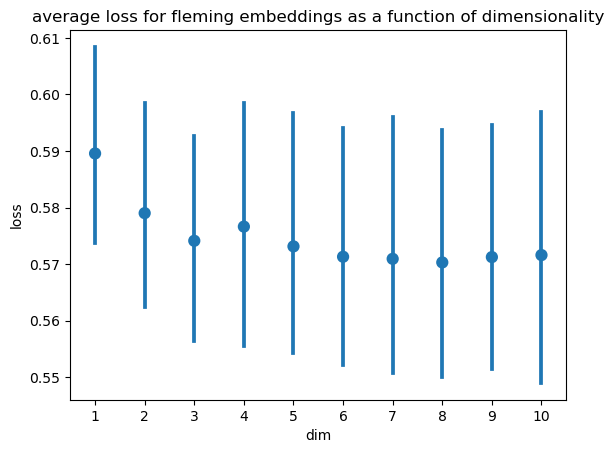

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23679/1797252572.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='dim',y='score',join= False,ci=95,data=d)


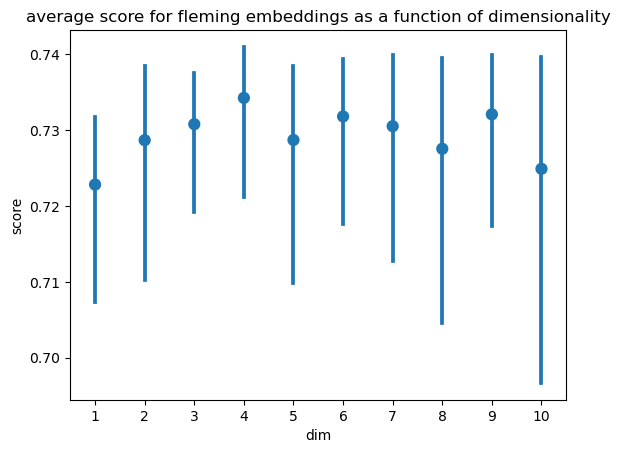

In [9]:
### plot the embedding loss and score as a function of dimensionality

dims=[]
cp_nums=[]
losses = []
scores=[]

for this_dim in salmon_fits_flem.keys():
    cp = 0
    for this_cp in salmon_fits_flem[this_dim].history_:
        dims.append(this_dim+1)
        cp_nums.append(cp)
        cp+=1
        losses.append(this_cp['loss_test'])
        scores.append(this_cp['score_test'])
d = pd.DataFrame(zip(dims,cp_nums,losses,scores),columns=['dim','cp_num','loss','score'])


sns.pointplot(x='dim',y='loss',join= False,ci=95,data=d)
plt.title('average loss for fleming embeddings as a function of dimensionality')
plt.show()

sns.pointplot(x='dim',y='score',join= False,ci=95,data=d)
plt.title('average score for fleming embeddings as a function of dimensionality')
plt.show()

### Fit models for sketches stimuli

In [10]:
if fit_online:
    X_train = dsketch[dsketch['sampler']=='Random']
    X_test = dsketch[dsketch['sampler']=='Validation']
    n = 128

    salmon_fits_sketch = {}
    X_train, X_test = X_train[["head", "winner", "loser"]].to_numpy(),X_test[["head", "winner", "loser"]].to_numpy()
    for i,d in enumerate([1,2,3,4,5,6]):
        model = OfflineEmbedding(n=n, d=d,max_epochs=8000,verbose=50)
        model.fit(X_train, X_test)
        salmon_fits_sketch[i] = model
    with open(os.path.join(data_dir,'salmon_embeddings/sketch.pkl'), 'wb') as f:
        pickle.dump(salmon_fits_sketch, f)
else:
    with open(os.path.join(data_dir,'salmon_embeddings/sketch.pkl'), 'rb') as f:
        salmon_fits_sketch = pickle.load(f)

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23679/1578244332.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='dim',y='loss',join= False,ci=95,data=d)


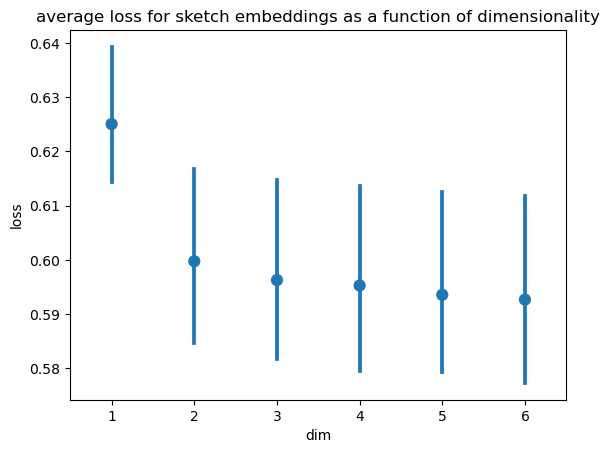

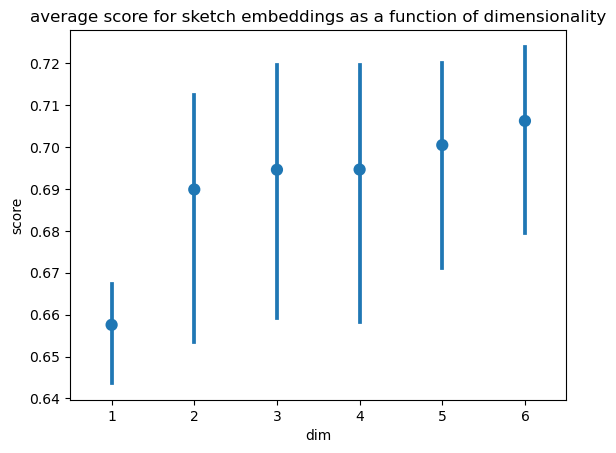

In [11]:
### plot the embedding loss and score as a function of dimensionality
dims=[]
cp_nums=[]
losses = []
scores=[]

for this_dim in salmon_fits_sketch.keys():
    cp = 0
    for this_cp in salmon_fits_sketch[this_dim].history_:
        dims.append(this_dim+1)
        cp_nums.append(cp)
        cp+=1
        losses.append(this_cp['loss_test'])
        scores.append(this_cp['score_test'])
d = pd.DataFrame(zip(dims,cp_nums,losses,scores),columns=['dim','cp_num','loss','score'])

sns.pointplot(x='dim',y='loss',join= False,ci=95,data=d)
plt.title('average loss for sketch embeddings as a function of dimensionality')
plt.show()

sns.pointplot(x='dim',y='score',join= False,errorbar='ci',data=d)
plt.title('average score for sketch embeddings as a function of dimensionality')
plt.show()


### Get information about inter-rater reliability

In [12]:
### create subsets of the each dataset with only the validation data
dsketch_val = dsketch[dsketch.sampler=='Validation'].sort_values(by='head').reset_index(drop=True)

dflem_val = dflem[dflem.sampler=='Validation'].sort_values(by='head').reset_index(drop=True)

## add a unique triplet id to each row
ids_=[]
for i,row in dsketch_val.iterrows():
    id_ = [row['head'],row['left'],row['right']]
    id_.sort()
    ids_.append(str(id_))
dsketch_val['triplet_id']=ids_


ids_=[]
for i,row in dflem_val.iterrows():
    id_ = [row['head'],row['left'],row['right']]
    id_.sort()
    ids_.append(str(id_))
dflem_val['triplet_id']=ids_


In [13]:
print('raw inter rater reliability for sketches:')
np.mean(dsketch_val.groupby('triplet_id').apply(lambda x: (x['winner'].value_counts().values[0]/len(x))).values)


raw inter rater reliability for sketches:


0.7318845434465683

In [14]:
print('raw inter rater reliability for fleming shapes:')
np.mean(dflem_val.groupby('triplet_id').apply(lambda x: (x['winner'].value_counts().values[0]/len(x))).values)

raw inter rater reliability for fleming shapes:


0.7376036045695489

### Load model features and visualize model and NEXT reps

In [15]:
### List of models we're using
model_paths =['alexnet_classifier.4','resnet18_layer4.1.conv2','vgg19_classifier.3','clip-ViT_visual','ViT_fc_norm']

In [16]:
### look at average ability for each model to predict human decisions
for this_stim in ['fleming_adjusted','sketches']:
    print(this_stim)
    for this_model in model_paths:
        df,cols =gen_feat_df(this_stim, this_model,show_pca=False)
        if this_stim=='fleming_adjusted':
            print(f'{this_model} proportion human decisions matched: {np.mean(score(df,dflem, cols))}')
        elif this_stim=='sketches':
            print(f'{this_model} proportion human decisions matched: {np.mean(score(df,dsketch, cols))}')
        


fleming_adjusted
alexnet_classifier.4 proportion human decisions matched: 0.621121321081369
resnet18_layer4.1.conv2 proportion human decisions matched: 0.6331069383406579
vgg19_classifier.3 proportion human decisions matched: 0.6276468238114263
clip-ViT_visual proportion human decisions matched: 0.6308429884139033
ViT_fc_norm proportion human decisions matched: 0.6153948595019311
sketches
alexnet_classifier.4 proportion human decisions matched: 0.6168997668997669
resnet18_layer4.1.conv2 proportion human decisions matched: 0.5991258741258741
vgg19_classifier.3 proportion human decisions matched: 0.61002331002331
clip-ViT_visual proportion human decisions matched: 0.6753496503496503
ViT_fc_norm proportion human decisions matched: 0.5912587412587412


### Sketch analysis

In [17]:
## load dataframe from semantic part annotation task
sp_df = pd.read_csv(os.path.join(data_dir,'semantic_parts_annotated_data.csv'))
sp_df.sketch_svg_string = sp_df.sketch_svg_string.apply(listify)

In [18]:
### creating a dataframe of stroke information
unique_cats = sp_df.category.unique()

stroke_svgs=OrderedDict()
for category in unique_cats:
    sp_df_=sp_df[sp_df['category']==category]
    for sketch in np.unique(sp_df_['sketch_id']):
        sp_df__=sp_df_[sp_df_['sketch_id']==sketch]
        for stroke in np.unique(sp_df__['stroke_num']):
            DSA=sp_df__[sp_df__['stroke_num']==stroke] ### a dataframe for a single stroke
            DSA=DSA.reset_index() 
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke] ## add to dict where key is the stroke_id and the value is the svg string for that stroke


stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')   ## dataframe of strokes and their associated svg string
stroke_group_data= sp_df.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0]) ## groups together all strokes across participants to get most common stroke information
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True) ### add svg strings to df
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"}) 

##Adding total arclength information to stroke dataframe

def calculate_arclength(svg):
    try:
        arclength= parse_path(svg).length()
    except ZeroDivisionError:
        print ('zero div error')
        arclength = 0
    return arclength
stroke_df['arc_length'] = stroke_df['svg'].apply(calculate_arclength)

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23679/3471633792.py:16: FutureWarning: ['sketch_svg_string'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stroke_group_data= sp_df.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0]) ## groups together all strokes across participants to get most common stroke information


In [19]:

##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}

##Create vectors that contain the number of part instances in each sketch
num_annots=3

for category in unique_cats:
    DS= sp_df[sp_df['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DSS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = DSA.label.values
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec/num_annots
    label_vect_dict[category]= Label_Vec

valid_labels=[]
valid_labels_dict={}
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 50
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(sp_df[sp_df['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels_dict[category]=plot_labels
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        DS=sp_df[sp_df['category']==category]
        prop_labels.append(DS[DS['label']==part]['annotation_id'].nunique()/DS['annotation_id'].nunique())
    
valid_labels = [item for sublist in valid_labels for item in sublist]

###This is where we make a num unique labels * 2 X number of sketches vector 
feature_vec = np.zeros((len(stroke_df.sketch_id.unique()),len(valid_labels)*2), dtype=int)
ind=0
start_pos=0
end_pos=0
meta_list=[]
cols = ['sketch_id','target','condition','category','outcome']

for cat in unique_cats:
  
    DS= stroke_df[stroke_df['category']==cat]
    unique_labels_in_cat=valid_labels_dict[cat]
    unique_sketches_in_cat=DS['sketch_id'].unique()
    start_pos = end_pos
    end_pos+= len(unique_labels_in_cat)
    # print (start_pos, end_pos)
    # clear_output(wait=True)
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)*2), dtype=int)
    arc_length_vec = np.zeros((len(unique_sketches_in_cat),len(valid_labels_dict[cat])), dtype=int)
    for s,sketch in enumerate(unique_sketches_in_cat):
        
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        arc_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSA=DS[DS['sketch_id']==sketch]
      
        meta_list.append(pd.Series([DSA['sketch_id'].unique(),DSA['target'].unique(),DSA['condition'].unique(),DSA['category'].unique(),DSA['outcome'].unique()], index=cols))
        label_list = DSA.label.values        
        for label in label_list:
            if label in unique_labels_in_cat:
                label_ind = unique_labels_in_cat==label
                label_vec[label_ind] += 1
        for label in unique_labels_in_cat:
            DSB=DSA[DSA['label']==label]
            label_ind = unique_labels_in_cat==label
            arc_vec[label_ind] = DSB['arc_length'].sum()
            
        
        feature_vec[ind,start_pos:end_pos]=label_vec
        feature_vec[ind,start_pos+len(valid_labels):end_pos+len(valid_labels)]=arc_vec
        ind+=1
meta_df = pd.DataFrame(meta_list, columns=cols)


In [20]:
##Changing column values from np arrays to strings/boolean

def arr_to_str(arr):
    return (arr[0])
meta_df['sketch_id']=meta_df['sketch_id'].apply(arr_to_str)
meta_df['target']=meta_df['target'].apply(arr_to_str)
meta_df['condition']=meta_df['condition'].apply(arr_to_str)
meta_df['category']=meta_df['category'].apply(arr_to_str)
meta_df['outcome']=meta_df['outcome'].apply(arr_to_str)
    
part_df= pd.DataFrame(feature_vec, columns=[s + '_numstrokes' for s in valid_labels]+[s + '_total_arclength' for s in valid_labels])


##Creating a compressed version of the feature df with no duplicates for parts. E.g. - no difference between
## dog leg and chair leg

labs_numstrokes=[]
labs_total_arclength=[]
for lab in np.unique(valid_labels):
    labs_numstrokes.append(lab +'_numstrokes')
    labs_total_arclength.append(lab+'_total_arclength')
feature_df_labs=labs_numstrokes+labs_total_arclength   
part_df_final= pd.DataFrame(columns=feature_df_labs)


for this_lab in feature_df_labs:
    duplicates=[col for col in part_df if col.startswith(this_lab)]
    part_df_final[this_lab]= part_df[duplicates].sum(axis=1)
part_df = part_df_final
part_df = normalize(part_df)

part_feats = pd.concat((meta_df,part_df),axis=1) ## dataframe for semantic part features
part_feat_cols= part_df.columns

In [21]:
### generate neural network features for sketches for each of the models and get the dataframe and column names

alex_sketch_df,alex_sketch_cols = gen_feat_df(stim='sketches',model_path =model_paths[0], show_pca=False) 

resnet_sketch_df,resnet_sketch_cols = gen_feat_df(stim='sketches',model_path =model_paths[1], show_pca=False) 

vgg_sketch_df, vgg_sketch_cols = gen_feat_df(stim='sketches',model_path =model_paths[2], show_pca=False) 

vit_sketch_df,vit_sketch_cols = gen_feat_df(stim='sketches',model_path =model_paths[3], show_pca=False) 

vit_nc_sketch_df,vit_nc_sketch_cols = gen_feat_df(stim='sketches',model_path =model_paths[4], show_pca=False)


In [22]:
### get only the part features for the sketches used in the triplet task
part_feats_sub = part_feats[part_feats.sketch_id.isin(vgg_sketch_df.sketch_id)]
part_feats_sub = part_feats_sub[part_feat_cols.append(pd.Index(['sketch_id']))] ## take only sketchid and feat columns

In [23]:
print(f"proportion of human judgements guessed correctly by embeddings: {np.mean(score(vgg_sketch_df, dsketch[dsketch.sampler=='Validation'], ['embed_1','embed_2']))}")

proportion of human judgements guessed correctly by embeddings: 0.7266514806378133


In [24]:
ho_acc = score(vgg_sketch_df, dsketch[dsketch.sampler=='Validation'], ['embed_1','embed_2']) ## holdot accuracy
### compute a one sample t-test between ho_acc and 0.7318845434465683 
from scipy.stats import ttest_1samp
ttest_1samp(ho_acc, 0.7318845434465683)


Ttest_1sampResult(statistic=-0.4918957422283792, pvalue=0.6228545667717504)

In [25]:
all_feats_df = pd.merge(vgg_sketch_df,part_feats_sub.reset_index(),on='sketch_id')
next_feat_cols = ['embed_1','embed_2']

In [26]:
from tqdm import tqdm, trange


### generate a matrix of Hu moment shape matching metrics across the sketches

all_feats_df = all_feats_df.sort_values(by=['category','target']).reset_index(drop=True)
#all_feats_df = all_feats_df.sort_values(by=['category','target']).reset_index(drop=True)

sm_dist_f = np.zeros((128,128))
for i in trange(all_feats_df.shape[0],position=0, leave=True):
    for j in range(all_feats_df.shape[0]):
        p1 = cv2.imread(os.path.join(data_dir,'sketches_stim/',all_feats_df.sketch_id[i]+'.png'),0)/255
        
        p2 = cv2.imread(os.path.join(data_dir,'sketches_stim/',all_feats_df.sketch_id[j]+'.png'),0)/255
        
        #get_diff
        sm_dist_f[i,j] = cv2.matchShapes(contour1= p1,contour2= p2,method= 1,parameter=None)

100%|██████████| 128/128 [00:31<00:00,  4.02it/s]


In [27]:

### generate a matrix of fft based high and low frequency shape matching metrics across the sketches

fft_low_dist_f = np.zeros((128,128))
fft_high_dist_f = np.zeros((128,128))
for i in trange(all_feats_df.shape[0],position=0, leave=True):
    for j in range(all_feats_df.shape[0]):
        p1 = fft_image(cv2.imread(os.path.join(data_dir,'sketches_stim/',all_feats_df.sketch_id[i]+'.png'),0)/255).flatten()  
        p2 = fft_image(cv2.imread(os.path.join(data_dir,'sketches_stim/',all_feats_df.sketch_id[j]+'.png'),0)/255).flatten()
        
        #get_diff
        fft_low_dist_f[i,j] = scipy.spatial.distance.cosine(p1,p2)

        p1 = fft_image(cv2.imread(os.path.join(data_dir,'sketches_stim/',all_feats_df.sketch_id[i]+'.png'),0)/255, high=True).flatten()  
        p2 = fft_image(cv2.imread(os.path.join(data_dir,'sketches_stim/',all_feats_df.sketch_id[j]+'.png'),0)/255, high=True).flatten()

        fft_high_dist_f[i,j] = scipy.spatial.distance.cosine(p1,p2)

100%|██████████| 128/128 [03:15<00:00,  1.53s/it]


In [28]:
cats = ['bird','car','chair','dog']
obj_list = []
cat_to_obj = {}
for this_cat in cats:
    fs = all_feats_df[all_feats_df.category == this_cat]
    obj_list.append(list(np.unique(fs.target.values)))
    cat_to_obj[this_cat] = list(np.unique(fs.target.values))

obj_list = [y for x in obj_list for y in x]

next_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        next_ob_means.append(np.array(all_feats_df[all_feats_df.target==this_ob][['embed_1','embed_2']].mean()))
        
next_ob_means = np.stack(next_ob_means)

In [29]:
alex_ob_means = []
resnet_ob_means = []
vgg_ob_means = []
vit_ob_means = []
vit_nc_ob_means = []


for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        alex_ob_means.append(np.array(alex_sketch_df[alex_sketch_df.target==this_ob][alex_sketch_cols].mean()))
        resnet_ob_means.append(np.array(resnet_sketch_df[resnet_sketch_df.target==this_ob][resnet_sketch_cols].mean()))
        vgg_ob_means.append(np.array(vgg_sketch_df[vgg_sketch_df.target==this_ob][vgg_sketch_cols].mean()))
        vit_ob_means.append(np.array(vit_sketch_df[vit_sketch_df.target==this_ob][vit_sketch_cols].mean()))
        vit_nc_ob_means.append(np.array(vit_nc_sketch_df[vit_nc_sketch_df.target==this_ob][vit_nc_sketch_cols].mean()))


alex_ob_means = np.stack(alex_ob_means)
resnet_ob_means = np.stack(resnet_ob_means)
vgg_ob_means = np.stack(vgg_ob_means)
vit_ob_means = np.stack(vit_ob_means)
vit_nc_ob_means = np.stack(vit_nc_ob_means)

In [30]:
part_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        part_ob_means.append(np.array(all_feats_df[all_feats_df.target==this_ob][part_feat_cols].mean()))
part_ob_means = np.stack(part_ob_means)

In [31]:
ob_cols = [y for x in [['embed_1','embed_2'], ['alex_'+ str(x) for x in alex_sketch_cols] ,\
    ['resnet_'+ str(x) for x in resnet_sketch_cols],\
         ['vgg_'+ str(x) for x in vgg_sketch_cols],\
             ['vit_clip' + str(x) for x in vit_sketch_cols],\
                ['vit_nc' + str(x) for x in vit_nc_sketch_cols],\
                 part_feat_cols] for y in x]

ob_means_all = np.concatenate((next_ob_means, alex_ob_means, resnet_ob_means, vgg_ob_means, vit_ob_means,vit_nc_ob_means, part_ob_means), axis=1)

all_ob_means = pd.DataFrame(ob_means_all,
                     columns = ob_cols)
all_ob_means['target'] = pd.Series(obj_list)
all_ob_means['category']= all_ob_means['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])


In [32]:
def plot_dmat(pdmat,save=True,fname='dmat', stim='sketch'):
    if stim=='sketch':
        plt.figure(figsize=(10,10))
        plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
        plt.tick_params(axis='both', labelsize=0, length = 0)
        plt.xticks(np.arange(128, step=4),all_ob_means.target,fontsize=16, rotation=90)
        plt.yticks(np.arange(128, step=4),all_ob_means.target,fontsize=16)
        cb = plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(fname, fontsize=30)
        if save==True:
            plt.savefig(f'{stim}_{fname}.pdf', bbox_inches='tight')
        plt.close()
    elif stim=='flem':
        plt.figure(figsize=(10,10))
        plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
        plt.tick_params(axis='both', labelsize=0, length = 0)
        cb = plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(fname, fontsize=30)
        if save==True:
            plt.savefig(f'{stim}_{fname}.pdf', bbox_inches='tight')
        plt.close()
        


In [33]:
# plt.figure(figsize=(10,10))
# plt.matshow(sm_dist_f,fignum=1,cmap=plt.get_cmap('viridis_r'))
# plt.tick_params(axis='both', labelsize=0, length = 0)
# # plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# # plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
# cb = plt.colorbar(fraction=0.046, pad=0.04)
# plt.title('shape matching distances', fontsize=25)
# plt.close()

In [34]:
# plt.figure(figsize=(10,10))
# plt.matshow(fft_low_dist_f,fignum=1,cmap=plt.get_cmap('viridis_r'))
# plt.tick_params(axis='both', labelsize=0, length = 0)
# # plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# # plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
# cb = plt.colorbar(fraction=0.046, pad=0.04)
# plt.title('low pass distances', fontsize=25)

# plt.close()

In [35]:
# plt.figure(figsize=(10,10))
# plt.matshow(fft_high_dist_f,fignum=1,cmap=plt.get_cmap('viridis_r'))
# plt.tick_params(axis='both', labelsize=0, length = 0)
# # plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# # plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
# cb = plt.colorbar(fraction=0.046, pad=0.04)
# plt.title('High pass distances', fontsize=25)

# plt.close()

In [36]:
cat_dist_f_mean = np.ones((32,32))
for i in range(all_ob_means.shape[0]):
    for j in range(all_ob_means.shape[0]):
        if all_ob_means.category[i] == all_ob_means.category[j]:
            cat_dist_f_mean[i,j]=0


# plt.figure(figsize=(10,10))
# plt.matshow(cat_dist_f_mean,fignum=1,cmap=plt.get_cmap('viridis_r'))
# plt.tick_params(axis='both', labelsize=0, length = 0)
# plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
# cb = plt.colorbar(fraction=0.046, pad=0.04)
# plt.title('cat_dist', fontsize=25)
# plt.savefig('cat_dist.pdf',bbox_inches='tight')
# plt.close()

In [37]:
all_feats_df = all_feats_df.sort_values(by=['category','target']).reset_index(drop=True)
alex_sketch_df = alex_sketch_df.sort_values(by=['category','target']).reset_index(drop=True)
resnet_sketch_df = resnet_sketch_df.sort_values(by=['category','target']).reset_index(drop=True)
vit_sketch_df = vit_sketch_df.sort_values(by=['category','target']).reset_index(drop=True)
vgg_sketch_df = vgg_sketch_df.sort_values(by=['category','target']).reset_index(drop=True)
vit_nc_sketch_df = vit_nc_sketch_df.sort_values(by=['category','target']).reset_index(drop=True)


# next_dist_f = scipy.spatial.distance.pdist(all_feats_df[next_feat_cols], metric='euclidean')
# next_dist_f = scipy.spatial.distance.squareform(next_dist_f)
next_dist_f= all_feats_df[next_feat_cols]

alex_dist_f = scipy.spatial.distance.pdist(alex_sketch_df[alex_sketch_cols], metric='cosine')
alex_dist_f = scipy.spatial.distance.squareform(alex_dist_f)

vgg_dist_f = scipy.spatial.distance.pdist(vgg_sketch_df[vgg_sketch_cols], metric='cosine')
vgg_dist_f = scipy.spatial.distance.squareform(vgg_dist_f)

resnet_dist_f = scipy.spatial.distance.pdist(resnet_sketch_df[resnet_sketch_cols], metric='cosine')
resnet_dist_f = scipy.spatial.distance.squareform(resnet_dist_f)

vit_dist_f = scipy.spatial.distance.pdist(vit_sketch_df[vit_sketch_cols], metric='cosine')
vit_dist_f = scipy.spatial.distance.squareform(vit_dist_f)

vit_nc_dist_f = scipy.spatial.distance.pdist(vit_nc_sketch_df[vit_nc_sketch_cols], metric='cosine')
vit_nc_dist_f = scipy.spatial.distance.squareform(vit_nc_dist_f)


part_dist_f = scipy.spatial.distance.pdist(all_feats_df[part_feat_cols], metric='cosine')
part_dist_f =  scipy.spatial.distance.squareform(part_dist_f)


In [38]:

cat_dist_f = np.ones((128,128))
for i in range(all_feats_df.shape[0]):
    for j in range(all_feats_df.shape[0]):
        if all_feats_df.category[i] == all_feats_df.category[j]:
            cat_dist_f[i,j]=0

In [39]:
##Do PCA and find optimal number of components
# pca_nn = PCA(n_components='mle', svd_solver='full')
# pca_nn.fit(nn_dist_f)



pca_vgg = PCA(n_components='mle', svd_solver='full')
pca_vgg.fit(vgg_dist_f)
plot_dmat(vgg_dist_f,save=True,fname='vgg_dist')

pca_alex = PCA(n_components='mle', svd_solver='full')
pca_alex.fit(alex_dist_f)
plot_dmat(alex_dist_f,save=True,fname='alex_dist')

pca_resnet = PCA(n_components='mle', svd_solver='full')
pca_resnet.fit(resnet_dist_f)
plot_dmat(resnet_dist_f,save=True,fname='resnet_dist')

pca_vit = PCA(n_components='mle', svd_solver='full')
pca_vit.fit(vit_dist_f)
plot_dmat(vit_dist_f,save=True,fname='vit_dist')

pca_vit_nc = PCA(n_components='mle', svd_solver='full')
pca_vit_nc.fit(vit_nc_dist_f)
plot_dmat(vit_nc_dist_f,save=True,fname='vit_nc_dist')

# pca_next = PCA( n_components='mle', svd_solver='full')
# pca_next.fit(next_dist_f)


u,s,v = scipy.linalg.svd(np.array(next_dist_f-np.mean(np.array(next_dist_f))), full_matrices=True)
u[:,0:2]*s
pca_next = (u[:,0:2]*s).T

next_dist_f = scipy.spatial.distance.pdist(all_feats_df[next_feat_cols], metric='euclidean')
next_dist_f = scipy.spatial.distance.squareform(next_dist_f)
plot_dmat(next_dist_f,save=True,fname='next_dist')

pca_parts = PCA( n_components='mle', svd_solver='full')
pca_parts.fit(part_dist_f)
plot_dmat(part_dist_f,save=True,fname='part_dist')

pca_cat = PCA(n_components='mle',  svd_solver='full')
pca_cat.fit(cat_dist_f)
plot_dmat(cat_dist_f,save=True,fname='cat_dist')

pca_sm = PCA( n_components='mle',  svd_solver='full')
pca_sm.fit(sm_dist_f)
plot_dmat(sm_dist_f,save=True,fname='sm_dist')

pca_fft_high = PCA( n_components='mle',  svd_solver='full')
pca_fft_high.fit(fft_high_dist_f)
plot_dmat(fft_high_dist_f,save=True,fname='fft_high_dist')

pca_fft_low = PCA( n_components='mle',  svd_solver='full')
pca_fft_low.fit(fft_low_dist_f)
plot_dmat(fft_low_dist_f,save=True,fname='fft_low_dist')

sketch_pca_coords={'vgg': pca_vgg,
                   'alex': pca_alex,
                   'resnet': pca_resnet, 
                    'vit': pca_vit,
                    'vit_nc': pca_vit_nc,
                    'next': pca_next,
                    'parts': pca_parts,
                    'cat': pca_cat,
                    'sm': pca_sm,
                    'fft_high': pca_fft_high,
                    'fft_low': pca_fft_low 
                    }


In [40]:
sketch_pca_coords['vgg'].components_

array([[ 0.03771547, -0.03728274,  0.03201984, ..., -0.05512478,
         0.11268849, -0.0380809 ],
       [-0.15916759,  0.0570067 , -0.06834447, ..., -0.09422709,
        -0.04643334, -0.11189271],
       [-0.01795028, -0.04344356, -0.14920963, ..., -0.10079573,
         0.00984818, -0.07325357],
       ...,
       [-0.0067486 , -0.11756162, -0.13525533, ..., -0.15914941,
         0.05357276, -0.00365022],
       [ 0.02613542, -0.06822655, -0.02773976, ...,  0.10608854,
         0.05911554,  0.1291063 ],
       [-0.07945744, -0.04881356,  0.09640523, ...,  0.05313387,
         0.19854617, -0.13368201]])

In [41]:

vgg_pred_dmat, vgg_pred_df = plot_tscores(nn_model='vgg',stimulus='sketch',pca_coords = sketch_pca_coords, num_comps=2, plot=False, return_pred_mat=True)

alex_pred_dmat, alex_pred_df   = plot_tscores(nn_model='alex',stimulus='sketch',pca_coords = sketch_pca_coords, num_comps=2, plot=False,return_pred_mat=True)

resnet_pred_dmat, resnet_pred_df = plot_tscores(nn_model='resnet',stimulus='sketch',pca_coords = sketch_pca_coords, num_comps=2, plot=False,return_pred_mat=True)

vit_pred_dmat, vit_pred_df = plot_tscores(nn_model='vit',stimulus='sketch',pca_coords = sketch_pca_coords, num_comps=2, plot=False,return_pred_mat=True)

vit_nc_pred_dmat, vit_nc_pred_df = plot_tscores(nn_model='vit_nc',stimulus='sketch',pca_coords = sketch_pca_coords, num_comps=2, plot=False,return_pred_mat=True)


In [42]:
# print('VGG: ', vgg_deltar,
#       'Alex: ', alex_deltar,
#       'Resnet: ', resnet_deltar,
#       'VitCLIP: ', vit_deltar,
#       'Vit: ', vit_nc_deltar)

vgg_pred_df.to_csv('../data/VGG_sketch.csv')
alex_pred_df.to_csv('../data/AlexNet_sketch.csv')
resnet_pred_df.to_csv('../data/ResNet_sketch.csv')
vit_pred_df.to_csv('../data/ViT_sketch.csv')
vit_nc_pred_df.to_csv('../data/ViT_NC_sketch.csv')


In [43]:
score_vgg = score(vgg_sketch_df, dsketch_val, vgg_sketch_cols)
score_alex = score(alex_sketch_df, dsketch_val, alex_sketch_cols)
score_resnet = score(resnet_sketch_df, dsketch_val, resnet_sketch_cols)
score_vit = score(vit_sketch_df, dsketch_val, vit_sketch_cols)
score_vit_nc = score(vit_nc_sketch_df, dsketch_val, vit_nc_sketch_cols)

score_parts = score(all_feats_df, dsketch_val, None,distmat=part_dist_f)
score_cats = score(all_feats_df, dsketch_val, None, distmat=cat_dist_f)
score_sm = score(all_feats_df, dsketch_val, None, distmat=sm_dist_f)
score_fft_high = score(all_feats_df, dsketch_val, None, distmat=fft_high_dist_f)
score_fft_low = score(all_feats_df, dsketch_val, None, distmat=fft_low_dist_f)
score_next = score(all_feats_df, dsketch_val, None, distmat=next_dist_f)

score_vgg_pred= score(all_feats_df, dsketch_val, None, distmat=vgg_pred_dmat)
score_alex_pred= score(all_feats_df, dsketch_val, None, distmat=alex_pred_dmat)
score_resnet_pred= score(all_feats_df, dsketch_val, None, distmat=resnet_pred_dmat)
score_vit_pred= score(all_feats_df, dsketch_val, None, distmat=vit_pred_dmat)
score_vit_nc_pred= score(all_feats_df, dsketch_val, None, distmat=vit_nc_pred_dmat)


### given the list of numbers in score_vgg_pred, compute its standard error
vgg_sem = 1.96*np.sqrt(np.mean(score_vgg)*(1-np.mean(score_vgg))/len(score_vgg))


parts_sem = 1.96*np.sqrt(np.mean(score_parts)*(1-np.mean(score_parts))/len(score_parts))
cat_sem = 1.96*np.sqrt(np.mean(score_cats)*(1-np.mean(score_cats))/len(score_cats))
sm_sem = 1.96*np.sqrt(np.mean(score_sm)*(1-np.mean(score_sm))/len(score_sm))
fft_high_sem = 1.96*np.sqrt(np.mean(score_fft_high)*(1-np.mean(score_fft_high))/len(score_fft_high))
fft_low_sem = 1.96*np.sqrt(np.mean(score_fft_low)*(1-np.mean(score_fft_low))/len(score_fft_low))
next_sem = 1.96*np.sqrt(np.mean(score_next)*(1-np.mean(score_next))/len(score_next))

vgg_sem = 1.96*np.sqrt(np.mean(score_vgg)*(1-np.mean(score_vgg))/len(score_vgg))
alex_sem = 1.96*np.sqrt(np.mean(score_alex)*(1-np.mean(score_alex))/len(score_alex))
resnet_sem = 1.96*np.sqrt(np.mean(score_resnet)*(1-np.mean(score_resnet))/len(score_resnet))
vit_sem = 1.96*np.sqrt(np.mean(score_vit)*(1-np.mean(score_vit))/len(score_vit))
vit_nc_sem = 1.96*np.sqrt(np.mean(score_vit_nc)*(1-np.mean(score_vit_nc))/len(score_vit_nc))


vgg_pred_sem= 1.96*np.sqrt(np.mean(score_vgg_pred)*(1-np.mean(score_vgg_pred))/len(score_vgg_pred))
alex_pred_sem= 1.96*np.sqrt(np.mean(score_alex_pred)*(1-np.mean(score_alex_pred))/len(score_alex_pred))
resnet_pred_sem= 1.96*np.sqrt(np.mean(score_resnet_pred)*(1-np.mean(score_resnet_pred))/len(score_resnet_pred))
vit_pred_sem= 1.96*np.sqrt(np.mean(score_vit_pred)*(1-np.mean(score_vit_pred))/len(score_vit_pred))
vit_nc_pred_sem= 1.96*np.sqrt(np.mean(score_vit_nc_pred)*(1-np.mean(score_vit_nc_pred))/len(score_vit_nc_pred))





print(f'Part based predictions = {np.round(np.mean(score_parts),3)} +/- {np.round(parts_sem,3) }')
print(f'Category based predictions = {np.round(np.mean(score_cats),3)} +/- { np.round(cat_sem,3) }')
print(f'Shape match based predictions = {np.round(np.mean(score_sm),3)} +/- { np.round(sm_sem ,3)}')
print(f'FFT High pass based predictions = {np.round(np.mean(score_fft_high),3)} +/- { np.round(fft_high_sem,3) }')
print(f'FFT Low pass based predictions = {np.round(np.mean(score_fft_low),3)} +/- { np.round(fft_low_sem,3) }')
print(f'Triplet Embedding based predictions = {np.round(np.mean(score_next),3)} +/- { np.round(next_sem,3) }')
print('')
print(f'VGG based predictions  = {np.round(np.mean(score_vgg),3)} +/- { np.round(vgg_sem,3) }')
print(f'AlexNet based predictions  = {np.round(np.mean(score_alex),3)} +/- { np.round(alex_sem,3) }')
print(f'ResNet based predictions  = {np.round(np.mean(score_resnet),3)} +/- { np.round(resnet_sem,3) }')
print(f'ViT based predictions  = {np.round(np.mean(score_vit),3)} +/- { np.round(vit_sem,3) }')
print(f'ViT-NC based predictions  = {np.round(np.mean(score_vit_nc),3)} +/- { np.round(vit_nc_sem,3) }')
print('')
print(f'VGG + handcrafted feats model predictions  = {np.round(np.mean(score_vgg_pred),3)} +/- { np.round(vgg_pred_sem,3) }')
print(f'AlexNet + handcrafted feats model  based predictions  = {np.round(np.mean(score_alex_pred),3)} +/- { np.round(alex_pred_sem,3) }')
print(f'ResNet + handcrafted feats model  based predictions  = {np.round(np.mean(score_resnet_pred),3)}   +/- { np.round(resnet_pred_sem,3) }')
print(f'ViT + handcrafted feats model  based predictions  = {np.round(np.mean(score_vit_pred),3)} +/- { np.round(vit_pred_sem,3) }')
print(f'ViT-NC + handcrafted feats model  based predictions  = {np.round(np.mean(score_vit_nc_pred),3)} +/- { np.round(vit_nc_pred_sem,3) }')




Part based predictions = 0.68 +/- 0.022
Category based predictions = 0.563 +/- 0.023
Shape match based predictions = 0.548 +/- 0.023
FFT High pass based predictions = 0.417 +/- 0.023
FFT Low pass based predictions = 0.501 +/- 0.023
Triplet Embedding based predictions = 0.727 +/- 0.021

VGG based predictions  = 0.535 +/- 0.023
AlexNet based predictions  = 0.558 +/- 0.023
ResNet based predictions  = 0.53 +/- 0.023
ViT based predictions  = 0.632 +/- 0.023
ViT-NC based predictions  = 0.548 +/- 0.023

VGG + handcrafted feats model predictions  = 0.694 +/- 0.022
AlexNet + handcrafted feats model  based predictions  = 0.703 +/- 0.021
ResNet + handcrafted feats model  based predictions  = 0.703   +/- 0.021
ViT + handcrafted feats model  based predictions  = 0.7 +/- 0.021
ViT-NC + handcrafted feats model  based predictions  = 0.727 +/- 0.021


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


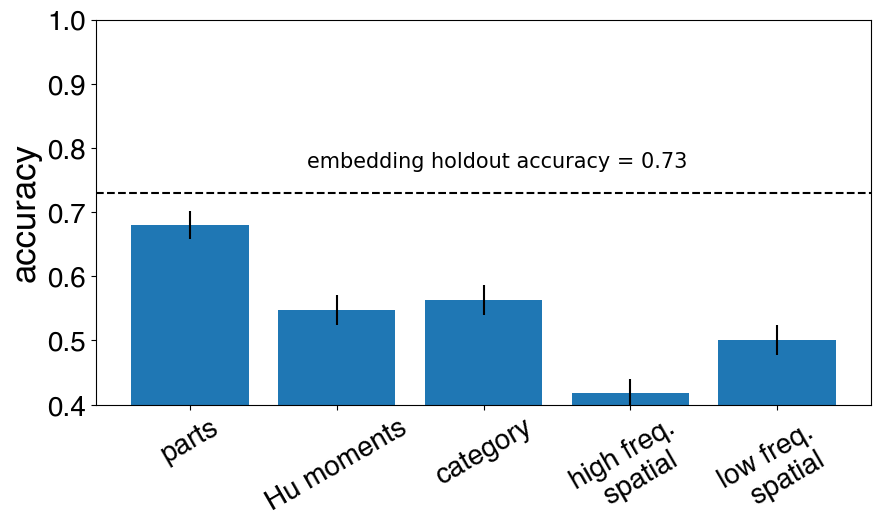

In [44]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,5),[np.mean(score_parts),\
                        np.mean(score_sm), np.mean(score_cats),\
                            np.mean(score_fft_high),np.mean(score_fft_low)])
plt.axhline(y=0.73,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.73', fontsize=15)
plt.xticks(np.arange(0,5),['parts','Hu moments','category','high freq.\n spatial','low freq. \n spatial'], rotation=30)
plt.errorbar(np.arange(0,5),[np.mean(score_parts),\
                        np.mean(score_sm), np.mean(score_cats),\
                              np.mean(score_fft_high),np.mean(score_fft_low)], yerr = [parts_sem,sm_sem, \
                                  cat_sem,fft_high_sem,fft_low_sem], color='k',ls='none')
plt.ylim(0.4,1)
plt.ylabel('accuracy',**lfont, fontsize=25)
plt.yticks(**lfont, fontsize=20)
plt.xticks(**lfont, fontsize=20)
plt.savefig('sketch_handcraft_accuracies.pdf', dpi=300, bbox_inches='tight', format='pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


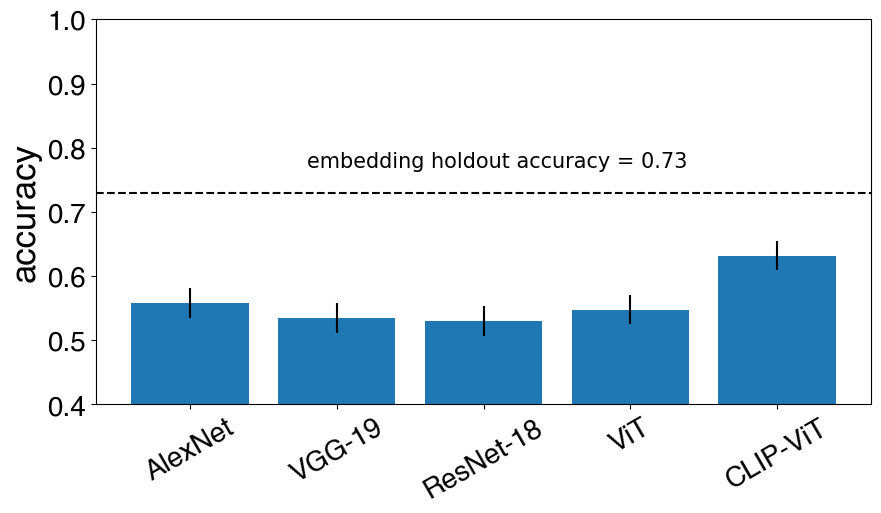

In [45]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,5),[np.mean(score_alex),\
                        np.mean(score_vgg), np.mean(score_resnet),\
                            np.mean(score_vit_nc),np.mean(score_vit)])
plt.axhline(y=0.73,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.73', fontsize=15)
plt.xticks(np.arange(0,5),['AlexNet','VGG-19','ResNet-18','ViT','CLIP-ViT'], rotation=30)
plt.errorbar(np.arange(0,5),[np.mean(score_alex),\
                        np.mean(score_vgg), np.mean(score_resnet),\
                                np.mean(score_vit_nc),np.mean(score_vit)], yerr = [alex_sem,vgg_sem, \
                                    resnet_sem,vit_nc_sem,vit_sem], color='k',ls='none')
plt.ylim(0.4,1)
plt.ylabel('accuracy',**lfont, fontsize=25)
plt.yticks(**lfont, fontsize=20)
plt.xticks(**lfont, fontsize=20)
plt.savefig('sketch_nn_accuracies.pdf', dpi=300, bbox_inches='tight', format='pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


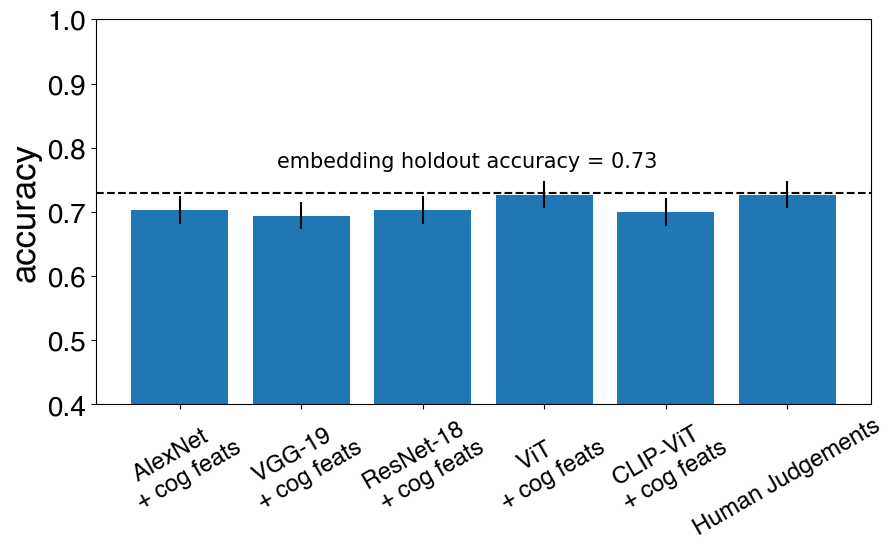

In [46]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,6),[np.mean(score_alex_pred),\
                        np.mean(score_vgg_pred), np.mean(score_resnet_pred),\
                            np.mean(score_vit_nc_pred),np.mean(score_vit_pred), np.mean(score_next)])
plt.axhline(y=0.73,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.73', fontsize=15)
plt.xticks(np.arange(0,6),['AlexNet \n + cog feats','VGG-19 \n + cog feats','ResNet-18 \n + cog feats','ViT \n + cog feats','CLIP-ViT \n + cog feats', 'Human Judgements'], rotation=30)
plt.errorbar(np.arange(0,6),[np.mean(score_alex_pred),\
                        np.mean(score_vgg_pred), np.mean(score_resnet_pred),\
                                np.mean(score_vit_nc_pred),np.mean(score_vit_pred),np.mean(score_next)], yerr = [alex_pred_sem,vgg_pred_sem, \
                                    resnet_pred_sem,vit_nc_pred_sem,vit_pred_sem,next_sem], color='k',ls='none')
plt.ylim(0.4,1)
plt.ylabel('accuracy',**lfont, fontsize=25)
plt.yticks(**lfont, fontsize=20)
plt.xticks(**lfont, fontsize=17)
plt.savefig('sketch_model_accuracies.pdf', dpi=300, bbox_inches='tight', format='pdf')


In [47]:
from scipy.stats import ttest_ind
print('p-values for the comparisons between the models')
print('')
print('p-value for the comparison between the triplet embedding based model and the VGG + handcrafted feats model predictions = ', ttest_ind(score_vgg_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the AlexNet + handcrafted feats model predictions = ', ttest_ind(score_alex_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the ResNet + handcrafted feats model predictions = ', ttest_ind(score_resnet_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the ViT-NC + handcrafted feats model predictions = ', ttest_ind(score_vit_nc_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the ViT + handcrafted feats model predictions = ', ttest_ind(score_vit_pred, score_next)[1])

p-values for the comparisons between the models

p-value for the comparison between the triplet embedding based model and the VGG + handcrafted feats model predictions =  0.033962851743230785
p-value for the comparison between the triplet embedding based model and the AlexNet + handcrafted feats model predictions =  0.1254528420347988
p-value for the comparison between the triplet embedding based model and the ResNet + handcrafted feats model predictions =  0.1254528420347988
p-value for the comparison between the triplet embedding based model and the ViT-NC + handcrafted feats model predictions =  1.0
p-value for the comparison between the triplet embedding based model and the ViT + handcrafted feats model predictions =  0.07952229343342733


In [48]:
alex_sketch_df.to_csv(os.path.join(data_dir,'alex_sketch_df.csv'),header=True)
resnet_sketch_df.to_csv(os.path.join(data_dir,'resnet_sketch_df.csv'),header=True)
vgg_sketch_df.to_csv(os.path.join(data_dir,'vgg_sketch_df.csv'),header=True)
vit_sketch_df.to_csv(os.path.join(data_dir,'vit_sketch_df.csv'),   header=True)
vit_nc_sketch_df.to_csv(os.path.join(data_dir,'vit_nc_sketch_df.csv'),header=True)

### Fleming Analysis

In [49]:
ndim = 2
# vgg_flem_df, vgg_flem_cols = gen_feat_df(stim='fleming_adjusted',model_path =model_paths[2], next_dims=ndim, show_pca=True) ##dataframe has vgg feats and next embeds


alex_flem_df,alex_flem_cols = gen_feat_df(stim='fleming_adjusted',model_path =model_paths[0], show_pca=False,next_dims=ndim) ##dataframe has alexnet feats and next embeds

resnet_flem_df,resnet_flem_cols = gen_feat_df(stim='fleming_adjusted',model_path =model_paths[1], show_pca=False,next_dims=ndim) 

vgg_flem_df, vgg_flem_cols = gen_feat_df(stim='fleming_adjusted',model_path =model_paths[2], show_pca=False,next_dims=ndim) ##dataframe has vgg feats and next embeds

vit_flem_df,vit_flem_cols = gen_feat_df(stim='fleming_adjusted',model_path =model_paths[3], show_pca=False,next_dims=ndim) 

vit_nc_flem_df,vit_nc_flem_cols = gen_feat_df(stim='fleming_adjusted',model_path =model_paths[4], show_pca=False,next_dims=ndim) 

print(f"proportion of human judgements guessed correctly by embeddings: {np.mean(score(vit_flem_df, dflem[dflem.sampler=='Validation'], ['embed_1','embed_2']))}")

proportion of human judgements guessed correctly by embeddings: 0.7409972299168975


In [50]:
vgg_flem_df['object'] = vgg_flem_df['sketch_id'].apply(lambda x:'-'.join(x.split('-')[1:]) )
alex_flem_df['object'] = alex_flem_df['sketch_id'].apply(lambda x:'-'.join(x.split('-')[1:]) )
resnet_flem_df['object'] = resnet_flem_df['sketch_id'].apply(lambda x:'-'.join(x.split('-')[1:]) )
vit_flem_df['object'] = vit_flem_df['sketch_id'].apply(lambda x:'-'.join(x.split('-')[1:]) )
vit_nc_flem_df['object'] = vit_nc_flem_df['sketch_id'].apply(lambda x:'-'.join(x.split('-')[1:]) )


In [51]:
next_feat_cols = ['embed_'+x for x in list(map(str,range(1,ndim+1)))]

In [52]:
from tqdm import tqdm, trange
vgg_flem_df =vgg_flem_df.sort_values(by=['category','object']).reset_index(drop=True)
sm_dist_f = np.zeros((64,64))
for i in trange(vgg_flem_df.shape[0],position=0, leave=True):
    for j in range(vgg_flem_df.shape[0]):
        p1 = cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim/',vgg_flem_df.sketch_id[i]+'.png'),0)/255
        
        p2 = cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim/',vgg_flem_df.sketch_id[j]+'.png'),0)/255
        
        #get_diff
        sm_dist_f[i,j] = cv2.matchShapes(contour1= p1,contour2= p2,method= 1,parameter=None)

100%|██████████| 64/64 [00:06<00:00,  9.77it/s]


In [53]:

overlap_dist_f = np.zeros((64,64))
for i in trange(vgg_flem_df.shape[0],position=0, leave=True):
    for j in range(vgg_flem_df.shape[0]):
        p1 = 1-cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim_filled/',vgg_flem_df.sketch_id[i]+'.png'),0)/255
        p2 = 1-cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim_filled/',vgg_flem_df.sketch_id[j]+'.png'),0)/255
        
        
        #get_diff
        overlap_dist_f[i,j] = np.sum(np.logical_and(p1,p2))/np.sum(np.logical_or(p1,p2))
overlap_dist_f = 1-overlap_dist_f

100%|██████████| 64/64 [00:08<00:00,  7.52it/s]


In [54]:

fft_low_dist_f = np.zeros((64,64))
fft_high_dist_f = np.zeros((64,64))
for i in trange(vgg_flem_df.shape[0],position=0, leave=True):
    for j in range(vgg_flem_df.shape[0]):
        p1 = fft_image(cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim/',vgg_flem_df.sketch_id[i]+'.png'),0)/255).flatten()  
        p2 = fft_image(cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim/',vgg_flem_df.sketch_id[j]+'.png'),0)/255).flatten()
        
        #get_diff
        fft_low_dist_f[i,j] = scipy.spatial.distance.cosine(p1,p2)

        p1 = fft_image(cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim/',vgg_flem_df.sketch_id[i]+'.png'),0)/255, high=True).flatten()  
        p2 = fft_image(cv2.imread(os.path.join(data_dir,'fleming_adjusted_stim/',vgg_flem_df.sketch_id[j]+'.png'),0)/255, high=True).flatten()

        fft_high_dist_f[i,j] = scipy.spatial.distance.cosine(p1,p2)

100%|██████████| 64/64 [03:14<00:00,  3.03s/it]


In [55]:
plt.figure(figsize=(10,10))
plt.matshow(sm_dist_f,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
# plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('shape matching distances',fontsize=25)

plt.close()

In [56]:
plt.figure(figsize=(10,10))
plt.matshow(overlap_dist_f,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
# plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('overlap_proportion',fontsize=25)

plt.close()

In [57]:
# next_dist_f = scipy.spatial.distance.pdist(vgg_flem_df[next_feat_cols], metric='euclidean')
# next_dist_f = scipy.spatial.distance.squareform(next_dist_f)

next_dist_f = vgg_flem_df[next_feat_cols]

vgg_dist_f = scipy.spatial.distance.pdist(vgg_flem_df[vgg_flem_cols], metric='cosine')
vgg_dist_f = scipy.spatial.distance.squareform(vgg_dist_f)

alex_dist_f = scipy.spatial.distance.pdist(alex_flem_df[alex_flem_cols], metric='cosine')
alex_dist_f = scipy.spatial.distance.squareform(alex_dist_f)

resnet_dist_f = scipy.spatial.distance.pdist(resnet_flem_df[resnet_flem_cols], metric='cosine')
resnet_dist_f = scipy.spatial.distance.squareform(resnet_dist_f)

vit_dist_f = scipy.spatial.distance.pdist(vit_flem_df[vit_flem_cols], metric='cosine')
vit_dist_f = scipy.spatial.distance.squareform(vit_dist_f)

vit_nc_dist_f = scipy.spatial.distance.pdist(vit_nc_flem_df[vit_nc_flem_cols], metric='cosine')
vit_nc_dist_f = scipy.spatial.distance.squareform(vit_nc_dist_f)



In [58]:


pca_vgg = PCA(n_components='mle', svd_solver='full')
pca_vgg.fit(vgg_dist_f)
plot_dmat(vgg_dist_f,save=True,fname='vgg_dist', stim='flem')

pca_alex = PCA(n_components='mle', svd_solver='full')
pca_alex.fit(alex_dist_f)
plot_dmat(alex_dist_f,save=True,fname='alex_dist', stim='flem')

pca_resnet = PCA(n_components='mle', svd_solver='full')
pca_resnet.fit(resnet_dist_f)
plot_dmat(resnet_dist_f,save=True,fname='resnet_dist', stim='flem')


pca_vit = PCA(n_components='mle', svd_solver='full')
pca_vit.fit(vit_dist_f)
plot_dmat(vit_dist_f,save=True,fname='vit_dist', stim='flem')


pca_vit_nc = PCA(n_components='mle', svd_solver='full')
pca_vit_nc.fit(vit_nc_dist_f)
plot_dmat(vit_nc_dist_f,save=True,fname='vit_nc_dist', stim='flem')

# pca_next = PCA( n_components='mle', svd_solver='full')
# pca_next.fit(np.array(next_dist_f))


u,s,v = scipy.linalg.svd(np.array(next_dist_f-np.mean(np.array(next_dist_f))), full_matrices=True)
u[:,0:2]*s
pca_next = (u[:,0:2]*s).T

next_dist_f = scipy.spatial.distance.pdist(vgg_flem_df[next_feat_cols], metric='euclidean')
next_dist_f = scipy.spatial.distance.squareform(next_dist_f)
plot_dmat(next_dist_f,save=True,fname='next_dist', stim='flem')


pca_sm = PCA( n_components=3,  svd_solver='full')
pca_sm.fit(sm_dist_f)
plot_dmat(sm_dist_f,save=True,fname='sm_dist', stim='flem')

pca_fft_high = PCA( n_components=3,  svd_solver='full')
pca_fft_high.fit(fft_high_dist_f)
plot_dmat(fft_high_dist_f,save=True,fname='fft_high_dist', stim='flem')

pca_fft_low = PCA( n_components=3,  svd_solver='full')
pca_fft_low.fit(fft_low_dist_f)
plot_dmat(fft_low_dist_f,save=True,fname='fft_low_dist', stim='flem')

pca_overlap = PCA( n_components=3,  svd_solver='full')
pca_overlap.fit(overlap_dist_f)
plot_dmat(overlap_dist_f,save=True,fname='overlap_dist', stim='flem')


flem_pca_coords={'vgg': pca_vgg,
                   'alex': pca_alex,
                   'resnet': pca_resnet, 
                    'vit': pca_vit,
                    'vit_nc': pca_vit_nc,
                    'next': pca_next,
                    'sm': pca_sm,
                    'fft_high': pca_fft_high,
                    'fft_low': pca_fft_low,
                    'overlap': pca_overlap
                    }

In [59]:

# vit_tmp, vit_f,vit_sub = plot_tscores_tmp(nn_model='resnet',stimulus='flem',num_comps=3, plot=False,return_pred_mat=True,pca_coords=flem_pca_coords)


In [60]:

vgg_pred_dmat, vgg_pred_df = plot_tscores(nn_model='vgg',stimulus='flem',num_comps=2, plot=False, return_pred_mat=True,pca_coords=flem_pca_coords)

alex_pred_dmat, alex_pred_df = plot_tscores(nn_model='alex',stimulus='flem',num_comps=2, plot=False,return_pred_mat=True,pca_coords=flem_pca_coords)

resnet_pred_dmat, resnet_pred_df = plot_tscores(nn_model='resnet',stimulus='flem',num_comps=2, plot=False,return_pred_mat=True,pca_coords=flem_pca_coords)

vit_pred_dmat, vit_pred_df = plot_tscores(nn_model='vit',stimulus='flem',num_comps=2, plot=False,return_pred_mat=True,pca_coords=flem_pca_coords)

vit_nc_pred_dmat, vit_nc_pred_df = plot_tscores(nn_model='vit_nc',stimulus='flem',num_comps=2, plot=False,return_pred_mat=True,pca_coords=flem_pca_coords)


In [61]:
# print('vgg', vgg_deltar,
#       'alex', alex_deltar,
#       'resnet', resnet_deltar
#       'vitCLIP', vit_deltar,
#       'vit', vit_nc_deltar)

vgg_pred_df.to_csv('../data/VGG_flem.csv')
alex_pred_df.to_csv('../data/AlexNet_flem.csv')
resnet_pred_df.to_csv('../data/ResNet_flem.csv')
vit_pred_df.to_csv('../data/ViT_flem.csv')
vit_nc_pred_df.to_csv('../data/ViT_NC_flem.csv')

In [62]:
score_vgg = score(vgg_flem_df, dflem_val, vgg_flem_cols)
score_alex = score(alex_flem_df, dflem_val, alex_flem_cols)
score_resnet = score(resnet_flem_df, dflem_val, resnet_flem_cols)
score_vit = score(vit_flem_df, dflem_val, vit_flem_cols)
score_vit_nc = score(vit_nc_flem_df, dflem_val, vit_nc_flem_cols)

score_overlap = score(vgg_flem_df, dflem_val, None,distmat=overlap_dist_f)
score_sm = score(vgg_flem_df, dflem_val, None, distmat=sm_dist_f)
score_fft_high = score(vgg_flem_df, dflem_val, None, distmat=fft_high_dist_f)
score_fft_low = score(vgg_flem_df, dflem_val, None, distmat=fft_low_dist_f)
score_next = score(vgg_flem_df, dflem_val, None, distmat=next_dist_f)

score_vgg_pred= score(vgg_flem_df, dflem_val, None, distmat=vgg_pred_dmat)
score_alex_pred= score(vgg_flem_df, dflem_val, None, distmat=alex_pred_dmat)
score_resnet_pred= score(vgg_flem_df, dflem_val, None, distmat=resnet_pred_dmat)
score_vit_pred= score(vgg_flem_df, dflem_val, None, distmat=vit_pred_dmat)
score_vit_nc_pred= score(vgg_flem_df, dflem_val, None, distmat=vit_nc_pred_dmat)


overlap_sem = 1.96*np.sqrt(np.mean(score_overlap)*(1-np.mean(score_overlap))/len(score_overlap))
sm_sem = 1.96*np.sqrt(np.mean(score_sm)*(1-np.mean(score_sm))/len(score_sm))
fft_high_sem = 1.96*np.sqrt(np.mean(score_fft_high)*(1-np.mean(score_fft_high))/len(score_fft_high))
fft_low_sem = 1.96*np.sqrt(np.mean(score_fft_low)*(1-np.mean(score_fft_low))/len(score_fft_low))
next_sem = 1.96*np.sqrt(np.mean(score_next)*(1-np.mean(score_next))/len(score_next))

vgg_sem = 1.96*np.sqrt(np.mean(score_vgg)*(1-np.mean(score_vgg))/len(score_vgg))
alex_sem = 1.96*np.sqrt(np.mean(score_alex)*(1-np.mean(score_alex))/len(score_alex))
resnet_sem = 1.96*np.sqrt(np.mean(score_resnet)*(1-np.mean(score_resnet))/len(score_resnet))
vit_sem = 1.96*np.sqrt(np.mean(score_vit)*(1-np.mean(score_vit))/len(score_vit))
vit_nc_sem = 1.96*np.sqrt(np.mean(score_vit_nc)*(1-np.mean(score_vit_nc))/len(score_vit_nc))


vgg_pred_sem= 1.96*np.sqrt(np.mean(score_vgg_pred)*(1-np.mean(score_vgg_pred))/len(score_vgg_pred))
alex_pred_sem= 1.96*np.sqrt(np.mean(score_alex_pred)*(1-np.mean(score_alex_pred))/len(score_alex_pred))
resnet_pred_sem= 1.96*np.sqrt(np.mean(score_resnet_pred)*(1-np.mean(score_resnet_pred))/len(score_resnet_pred))
vit_pred_sem= 1.96*np.sqrt(np.mean(score_vit_pred)*(1-np.mean(score_vit_pred))/len(score_vit_pred))
vit_nc_pred_sem= 1.96*np.sqrt(np.mean(score_vit_nc_pred)*(1-np.mean(score_vit_nc_pred))/len(score_vit_nc_pred))


print(f'Overlap based predictions = {np.round(np.mean(score_overlap),3)} +/- { np.round(overlap_sem,3) }')
print(f'Shape match based predictions = {np.round(np.mean(score_sm),3)} +/- { np.round(sm_sem ,3)}')
print(f'FFT High pass based predictions = {np.round(np.mean(score_fft_high),3)} +/- { np.round(fft_high_sem,3) }')
print(f'FFT Low pass based predictions = {np.round(np.mean(score_fft_low),3)} +/- { np.round(fft_low_sem,3) }')
print(f'Triplet Embedding based predictions = {np.round(np.mean(score_next),3)} +/- { np.round(next_sem,3) }')
print('')
print(f'VGG based predictions  = {np.round(np.mean(score_vgg),3)} +/- { np.round(vgg_sem,3) }')
print(f'AlexNet based predictions  = {np.round(np.mean(score_alex),3)} +/- { np.round(alex_sem,3) }')
print(f'ResNet based predictions  = {np.round(np.mean(score_resnet),3)} +/- { np.round(resnet_sem,3) }')
print(f'ViT based predictions  = {np.round(np.mean(score_vit),3)} +/- { np.round(vit_sem,3) }')
print(f'ViT-NC based predictions  = {np.round(np.mean(score_vit_nc),3)} +/- { np.round(vit_nc_sem,3) }')
print('')
print(f'VGG + handcrafted feats model predictions  = {np.round(np.mean(score_vgg_pred),3)} +/- { np.round(vgg_pred_sem,3) }')
print(f'AlexNet + handcrafted feats model  based predictions  = {np.round(np.mean(score_alex_pred),3)} +/- { np.round(alex_pred_sem,3) }')
print(f'ResNet + handcrafted feats model  based predictions  = {np.round(np.mean(score_resnet_pred),3)}   +/- { np.round(resnet_pred_sem,3) }')
print(f'ViT + handcrafted feats model  based predictions  = {np.round(np.mean(score_vit_pred),3)} +/- { np.round(vit_pred_sem,3) }')
print(f'ViT-NC + handcrafted feats model  based predictions  = {np.round(np.mean(score_vit_nc_pred),3)} +/- { np.round(vit_nc_pred_sem,3) }')




Overlap based predictions = 0.429 +/- 0.036
Shape match based predictions = 0.654 +/- 0.035
FFT High pass based predictions = 0.608 +/- 0.036
FFT Low pass based predictions = 0.356 +/- 0.035
Triplet Embedding based predictions = 0.741 +/- 0.032

VGG based predictions  = 0.68 +/- 0.034
AlexNet based predictions  = 0.68 +/- 0.034
ResNet based predictions  = 0.684 +/- 0.034
ViT based predictions  = 0.64 +/- 0.035
ViT-NC based predictions  = 0.645 +/- 0.035

VGG + handcrafted feats model predictions  = 0.715 +/- 0.033
AlexNet + handcrafted feats model  based predictions  = 0.711 +/- 0.033
ResNet + handcrafted feats model  based predictions  = 0.712   +/- 0.033
ViT + handcrafted feats model  based predictions  = 0.737 +/- 0.032
ViT-NC + handcrafted feats model  based predictions  = 0.715 +/- 0.033


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


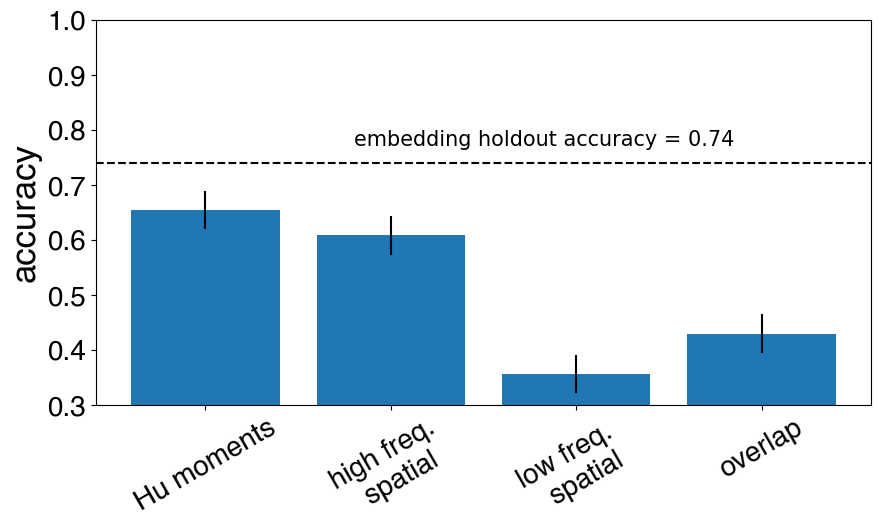

In [63]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,4),[np.mean(score_sm), np.mean(score_fft_high),np.mean(score_fft_low), np.mean(score_overlap)])
plt.axhline(y=0.74,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.74', fontsize=15)
plt.xticks(np.arange(0,4),['Hu moments','high freq.\n spatial','low freq. \n spatial','overlap'], rotation=30)
plt.errorbar(np.arange(0,4),[np.mean(score_sm), np.mean(score_fft_high),np.mean(score_fft_low),np.mean(score_overlap)], yerr = [sm_sem, \
                                  fft_high_sem,fft_low_sem, overlap_sem], color='k',ls='none')
plt.ylim(0.3,1)
plt.ylabel('accuracy',**lfont, fontsize=25)
plt.yticks(**lfont, fontsize=20)
plt.xticks(**lfont, fontsize=20)
plt.savefig('flem_handcraft_accuracies.pdf', dpi=300, bbox_inches='tight', format='pdf')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


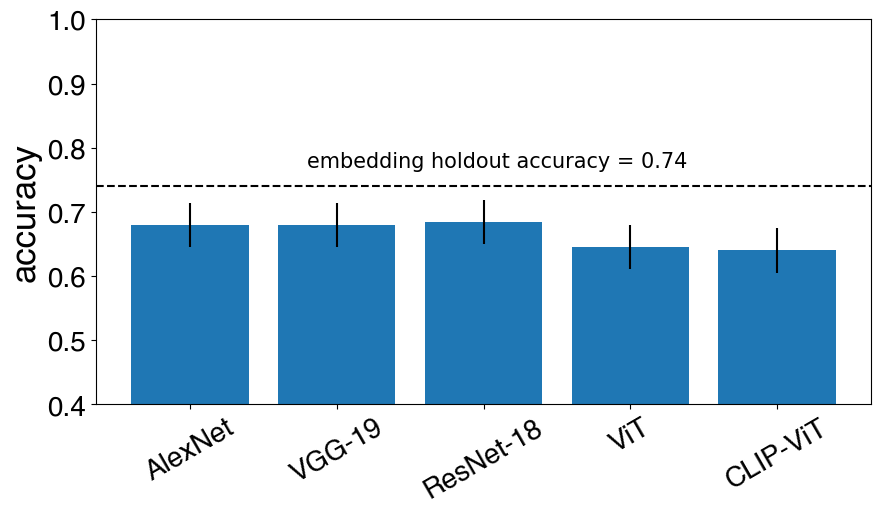

In [64]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,5),[np.mean(score_alex),\
                        np.mean(score_vgg), np.mean(score_resnet),\
                            np.mean(score_vit_nc),np.mean(score_vit)])
plt.axhline(y=0.74,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.74', fontsize=15)
plt.xticks(np.arange(0,5),['AlexNet','VGG-19','ResNet-18','ViT','CLIP-ViT'], rotation=30)
plt.errorbar(np.arange(0,5),[np.mean(score_alex),\
                        np.mean(score_vgg), np.mean(score_resnet),\
                                np.mean(score_vit_nc),np.mean(score_vit)], yerr = [alex_sem,vgg_sem, \
                                    resnet_sem,vit_nc_sem,vit_sem], color='k',ls='none')
plt.ylim(0.4,1)
plt.ylabel('accuracy',**lfont, fontsize=25)
plt.yticks(**lfont, fontsize=20)
plt.xticks(**lfont, fontsize=20)
plt.savefig('flem_nn_accuracies.pdf', dpi=300, bbox_inches='tight', format='pdf')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


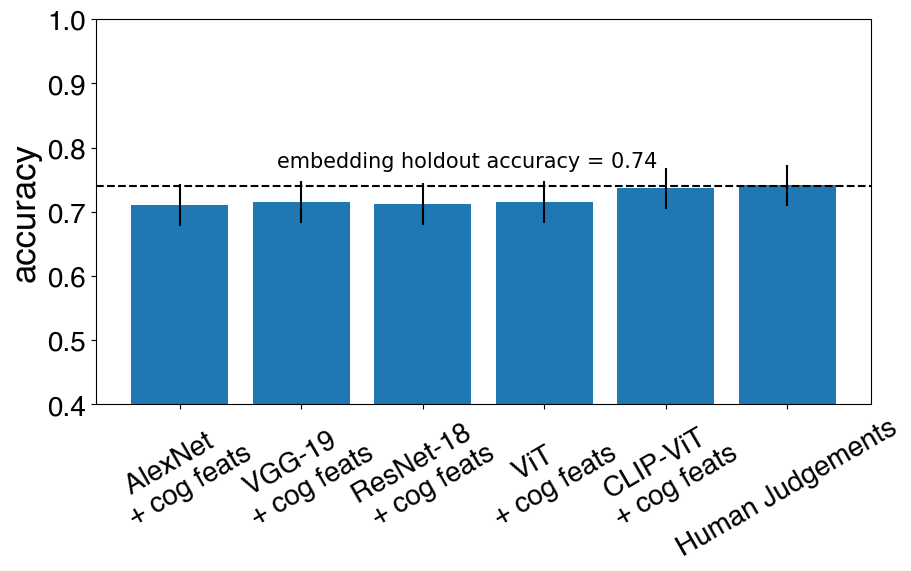

In [65]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,6),[np.mean(score_alex_pred),\
                        np.mean(score_vgg_pred), np.mean(score_resnet_pred),\
                            np.mean(score_vit_nc_pred),np.mean(score_vit_pred), np.mean(score_next)])
plt.axhline(y=0.74,linestyle='dashed',color='k')
plt.text(0.8,.77,'embedding holdout accuracy = 0.74', fontsize=15)
plt.xticks(np.arange(0,6),['AlexNet \n + cog feats','VGG-19 \n + cog feats','ResNet-18 \n + cog feats','ViT \n + cog feats','CLIP-ViT \n + cog feats', 'Human Judgements'], rotation=30)
plt.errorbar(np.arange(0,6),[np.mean(score_alex_pred),\
                        np.mean(score_vgg_pred), np.mean(score_resnet_pred),\
                                np.mean(score_vit_nc_pred),np.mean(score_vit_pred),np.mean(score_next)], yerr = [alex_pred_sem,vgg_pred_sem, \
                                    resnet_pred_sem,vit_nc_pred_sem,vit_pred_sem,next_sem], color='k',ls='none')
plt.ylim(0.4,1)
plt.ylabel('accuracy',**lfont, fontsize=25)
plt.yticks(**lfont, fontsize=20)
plt.xticks(**lfont, fontsize=20)
plt.savefig('flem_model_accuracies.pdf', dpi=300, bbox_inches='tight',format='pdf')


In [66]:
### calculate the p-values for the comparisons between the models
print('p-values for the comparisons between the models')
print('')
print('p-value for the comparison between the triplet embedding based model and the VGG + handcrafted feats model predictions = ', ttest_ind(score_vgg_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the AlexNet + handcrafted feats model predictions = ', ttest_ind(score_alex_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the ResNet + handcrafted feats model predictions = ', ttest_ind(score_resnet_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the ViT-NC + handcrafted feats model predictions = ', ttest_ind(score_vit_nc_pred, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and the ViT + handcrafted feats model predictions = ', ttest_ind(score_vit_pred, score_next)[1])

p-values for the comparisons between the models

p-value for the comparison between the triplet embedding based model and the VGG + handcrafted feats model predictions =  0.2615709520536029
p-value for the comparison between the triplet embedding based model and the AlexNet + handcrafted feats model predictions =  0.19464300496097436
p-value for the comparison between the triplet embedding based model and the ResNet + handcrafted feats model predictions =  0.2153617198349674
p-value for the comparison between the triplet embedding based model and the ViT-NC + handcrafted feats model predictions =  0.2615709520536029
p-value for the comparison between the triplet embedding based model and the ViT + handcrafted feats model predictions =  0.8574757593291673


In [67]:
## extra test, just see if the neural net featuers do well

print('p-values for the comparisons between the models')
print('')
print('p-value for the comparison between the triplet embedding based model and VGG-19 = ', ttest_ind(score_vgg, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and AlexNet = ', ttest_ind(score_alex, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and ResNet-18 = ', ttest_ind(score_resnet, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and ViT-NC = ', ttest_ind(score_vit_nc, score_next)[1])
print('p-value for the comparison between the triplet embedding based model and ViT = ', ttest_ind(score_vit, score_next)[1])


p-values for the comparisons between the models

p-value for the comparison between the triplet embedding based model and VGG-19 =  0.01065501488438964
p-value for the comparison between the triplet embedding based model and AlexNet =  0.01065501488438964
p-value for the comparison between the triplet embedding based model and ResNet-18 =  0.017104835822613098
p-value for the comparison between the triplet embedding based model and ViT-NC =  7.991643256404598e-05
p-value for the comparison between the triplet embedding based model and ViT =  3.124180036934426e-05


In [68]:
# plt.figure(figsize=(20,20))
# plt.matshow(coord_dmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
# plt.tick_params(axis='both', labelsize=0, length = 0)
# # plt.xticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16, rotation=90)
# # plt.yticks(range(all_ob_means.shape[0]),all_ob_means.target,fontsize=16)
# cb = plt.colorbar(fraction=0.046, pad=0.04)
# plt.title('Predicted NEXT coordinate distances',fontsize=50)
# plt.show()

In [69]:


alex_flem_df.to_csv(os.path.join(data_dir,'alex_flem_df.csv'),header=True)
resnet_flem_df.to_csv(os.path.join(data_dir,'resnet_flem_df.csv'),header=True)
vgg_flem_df.to_csv(os.path.join(data_dir,'vgg_flem_df.csv'),header=True)
vit_flem_df.to_csv(os.path.join(data_dir,'vit_flem_df.csv'),   header=True)
vit_nc_flem_df.to_csv(os.path.join(data_dir,'vit_nc_flem_df.csv'),header=True)